In [1]:
#%matplotlib widget
#%matplotlib ipympl
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit

'''
from matplotlib.ticker import LogFormatter 
from matplotlib import ticker, cm
import matplotlib as mpl
import copy
import os
import h5py
import json
import PyPDF2                       
import glob                         
from collections.abc import Iterable
import succolib as suc
import math
'''

import sys 
Swan_h = ("swan" in sys.executable) or ("cern" in sys.executable)
# print('Swan ', Swan_h)

In [ ]:
######################## MATERIAL AND YEAR #####################
year = 2025
material = 'W_12mm'
######################## SET RUN NUMBER #####################
run_ax = [720699, 720700,720734, 720739]
run_rnd = [720668,720754,720756,720757,720760,720768,720770]

run = [730133 ] 

######################## SET CUT AND SELECTIONS #####################

### CALORIMETER ###
Calibration = False ##toggle calibration
Corr_Factor=0.6
th_calo_ph = 0.1
n_bin_calo = np.arange(th_calo_ph,6.5,0.05) if Calibration else 300

### POSITION ###  {NDR IT SHOULD BE TAKEN BY THE JSON FILE}
Cut_pos = True ##toggle cut on crystal
chamb_dim = [0,10]
if Cut_pos:
    if run in range(720686,720693):
        pos_cut_x=[5.2,5.8]
        pos_cut_y=[4.7,5.45]
        # pos_cut_x=[4.6,6]  ## LARGE TO BE SURE THAT THE NOT POS IS OUT
        # pos_cut_y=[4.5,6]  ## LARGE TO BE SURE THAT THE NOT POS IS OUT
    else:
        pos_cut_x= [5,5.6] 
        pos_cut_y= [4.8,5.4]
        # pos_cut_x= [4.7,5.8]  ## LARGE TO BE SURE THAT THE NOT POS IS OUT
        # pos_cut_y= [4.5,5.6] ## LARGE TO BE SURE THAT THE NOT POS IS OUT 
else:
    pos_cut_x= chamb_dim
    pos_cut_y= chamb_dim
    
bins_2d = [100,100]
# bins_2d = [np.arange(0,10,0.0242),np.arange(0,10,0.0242)] ## one bin for strip @@@CHECK!

### ANGLE ###
Cut_theta= False
theta_crit = 570 #urad
theta_cut = 1000 if Cut_theta else 1000000#  3*theta_crit #100000

### OTHER TO BE FILLED ##

th_cherry = 21

th_scinti_magnet = 2600
th_scinti_desy = 350



In [3]:
import Utils
from Utils import *

## Import dictionary from the json
dizi, mycmap = configurator(year,material,Swan_h)  

m = dizi['slope_Calo']
q = dizi['intercept_Calo']

#### Open the file and import the data
xpos,xinfo,ph,tm,evi,info_plus,\
ph_cherry1,ph_cherry2,ph_scinti_desy,ph_scinti_after_magnet,ph_calo_photon,ph_calo_elect1,ph_calo_elect2,ph_apc1,ph_apc2,\
x1,y1,x2,y2,x_cry,y_cry,theta_in_x,theta_in_y, = file_corrector(run)
theta_in_x -= 2500 ## for the moment alignement not  working

if Calibration:
    ph_calo_photon = (ph_calo_photon - q)/m
    ph_calo_elect1 = (ph_calo_elect1*3.8 - q)/m
    ph_calo_elect2 = (ph_calo_elect2*4.2- q)/m

###### LOGI SEtting #####     
 
logix = (x2>pos_cut_x[0]) & (x2<pos_cut_x[1])
logiy = (y2>pos_cut_y[0]) & (y2<pos_cut_y[1])

logi_pos = logix & logiy
logi_calo_ph = (ph_calo_photon > th_calo_ph)
logi_scinti = (ph_scinti_desy > 0.1)
logi_cherry = (ph_cherry1 > th_cherry)
logi_angle = ((theta_in_x)**2 + (theta_in_y)**2) < (theta_cut)**2

logi_time_calo_ph =  (abs((tm[:,2] - tm[:,6]) + 18.5) < 1.5)  ##- 17,-20 
logi_time_el1 =  (abs((tm[:,3] - tm[:,6]) + 18.5) < 1.5)  ##- 17,-20 
logi_time_pad =  (abs((tm[:,5] - tm[:,6])) < 2)  ## -2,+2

### THIS ONE IS THE MAIN LOGIC  ###
logi = logi_pos  
### ###### ###### ###### ###### ###
for xinf in xinfo[0,:]:
    print(f'{xinf:.2f}')

2999.33
-18149.94
17.00
0.00
0.00


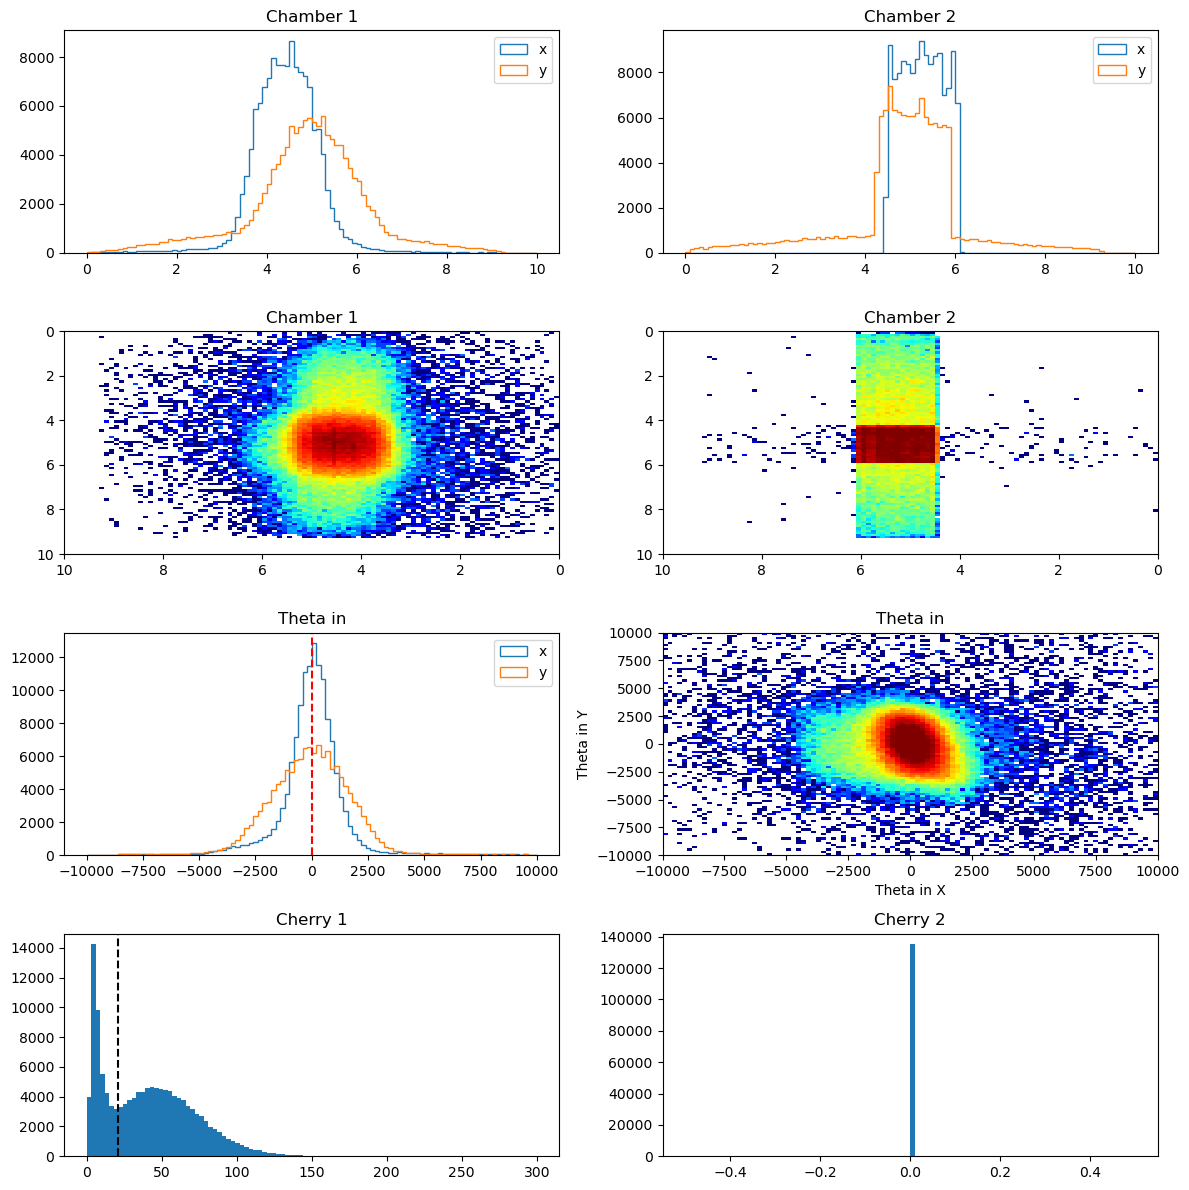

In [4]:
#### PLOT Pos and theta ### 
opts_2d = { "cmap" : mycmap, "norm" : mpl.colors.LogNorm()}
opts = {"range" : chamb_dim, "histtype":'step'}
fig, ax = plt.subplots(4,2)
fig.set_size_inches(12, 12)

### Chamber 1 ###
ax[0,0].hist(x1, bins=bins_2d[0],label='x',**opts)
ax[0,0].hist(y1, bins=bins_2d[1],label='y',**opts)
ax[1,0].hist2d(x1,y1, bins=bins_2d,range=[chamb_dim,chamb_dim],**opts_2d)
ax[0,0].set_title('Chamber 1')
ax[0,0].legend()
ax[1,0].set_title('Chamber 1')
ax[1,0].invert_xaxis()
ax[1,0].invert_yaxis()

### Chamber 2 ###
ax[0,1].hist(x2, bins=bins_2d[0],label='x',**opts)
ax[0,1].hist(y2, bins=bins_2d[1],label='y',**opts)
ax[1,1].hist2d(x2,y2, bins=bins_2d,range=[chamb_dim,chamb_dim],**opts_2d)
ax[0,1].set_title('Chamber 2')
ax[0,1].legend()
ax[1,1].set_title('Chamber 2')
ax[1,1].invert_xaxis()
ax[1,1].invert_yaxis()

### Chamber theta ###
ax[2,0].hist(theta_in_x, bins=bins_2d[0],range=[-10000,10000],histtype='step',label='x')
ax[2,0].hist(theta_in_y, bins=bins_2d[1],range=[-10000,10000],histtype='step',label='y')
ax[2,0].axvline(x=0, color='r', ls = '--')
# print(np.std(theta_in_x),np.std(theta_in_y))
ax[2,1].hist2d(theta_in_x,theta_in_y, bins=bins_2d,range=[[-10000,10000],[-10000,10000]],**opts_2d)
ax[2,0].set_title('Theta in')
ax[2,0].legend()
ax[2,1].set_title('Theta in')
ax[2,1].set_xlabel('Theta in X')
ax[2,1].set_ylabel('Theta in Y')

### Select what to see ### 
show_apc = False
show_cherry = True
show_times = False

if show_apc:
    logi_apc = logi & (ph_apc1> 75) & (ph_apc2 >75)
    logi_apc = logi 
    ax[3,0].hist(ph_apc1[logi_apc],bins=100,)
    ax[3,1].hist(ph_apc2[logi_apc],bins=100,)
    ax[3,0].set_title('APC 1')
    ax[3,1].set_title('APC 2')
elif show_cherry:
    ax[3,0].hist(ph_cherry1,bins=100,range=[0,300])
    ax[3,1].hist(ph_cherry2,bins=100,)
    ax[3,0].set_title('Cherry 1')
    ax[3,1].set_title('Cherry 2')
    ax[3,0].axvline(x=th_cherry, c = 'k', ls = '--')
elif show_times:
    diff_2 =tm[:,6]-tm[:,2]
    diff_4 =tm[:,6]-tm[:,4]
    ax[3,0].hist(diff_2[logi_cherry],bins=25,range=[0,25])
    ax[3,1].hist(diff_4[logi_cherry],bins=1000,range=[-500,500])
    ax[3,0].set_title('Tm Cherry - LG CC ')
    ax[3,1].set_title('Tm Cherry - LG Dx2 ')

plt.tight_layout()
plt.show()


## Crystal search on xy maps

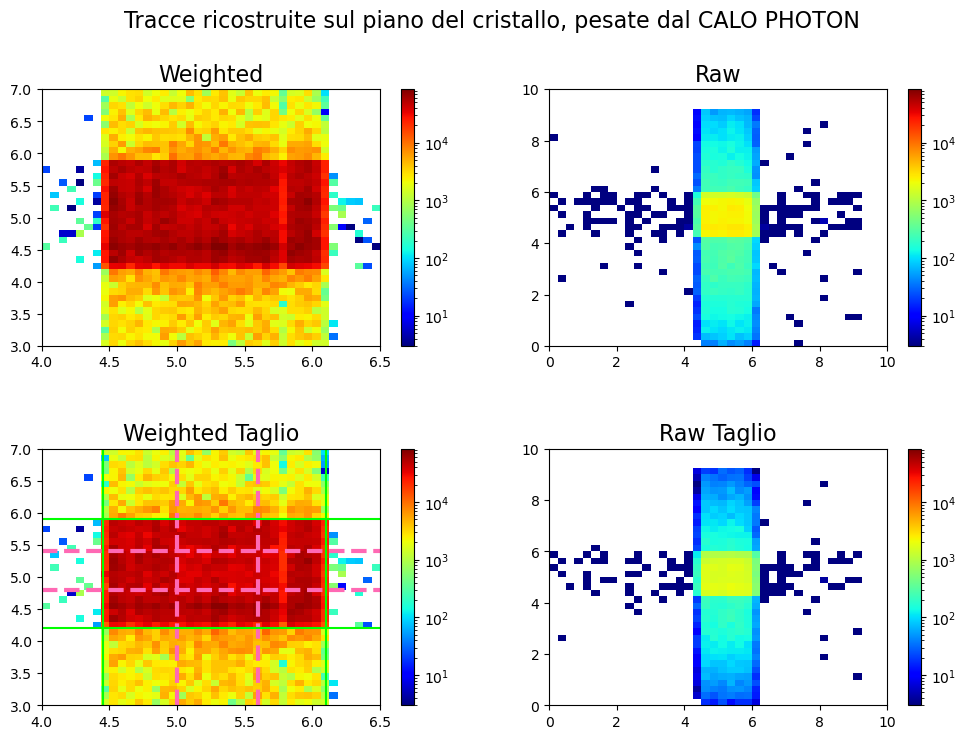

In [5]:
### SEARCH THE CRYSTAL ON LG (usefull for thin crytsal alignement on radiation [and Auto Trigger open])###
opts_2d = { "cmap" : mycmap, "norm" : mpl.colors.LogNorm()}
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,8)
fig.subplots_adjust(hspace=.4)
fig.suptitle(f"Tracce ricostruite sul piano del cristallo, pesate dal CALO PHOTON", fontsize = 16)
ax = ax.flatten()

hh = ax[0].hist2d(x2, y2, bins = 40, weights = ph_calo_photon,
                range = ((4,6.5),(3,7)),**opts_2d)
                # range = ((4,7),(3,7)),norm = mpl.colors.LogNorm(), **opts_2d)
                # range = ((0,10),(0,10)),norm = mpl.colors.LogNorm(), **opts_2d)
fig.colorbar(hh[3], ax = ax[0])

hh = ax[1].hist2d(x2, y2, bins = 40, 
                range = ((0,10),(0,10)), **opts_2d)
                # range = ((0,10),(0,10)),norm = mpl.colors.LogNorm(), **opts_2d)
fig.colorbar(hh[3], ax = ax[1])
ax[0].set_title("Weighted", fontsize = 16)
ax[1].set_title("Raw", fontsize = 16)

# logi_taglio = logi_cherry & (Scinti_after_magnet > 40)
logi_taglio = logi_cherry # & (Calo_elect1 > 80) #(Calo_photon < 40) & 

hh = ax[2].hist2d(x2[logi_taglio], y2[logi_taglio], bins = 40, weights = ph_calo_photon[logi_taglio],
                range = ((4,6.5),(3,7)), **opts_2d)
                # range = ((4,7),(3,7)),norm = mpl.colors.LogNorm(), **opts_2d)
                # range = ((0,10),(0,10)), **opts_2d)
fig.colorbar(hh[3], ax = ax[2])

hh = ax[3].hist2d(x2[logi_taglio], y2[logi_taglio], bins = 40, 
                # range = ((4,7),(3,7)),norm = mpl.colors.LogNorm(), **opts_2d)
                range = ((0,10),(0,10)), **opts_2d)
fig.colorbar(hh[3], ax = ax[3])
ax[2].set_title("Weighted Taglio", fontsize = 16)
ax[3].set_title("Raw Taglio", fontsize = 16)

#### add lines of cut and autotrigger##
ax[2].axvline(x = pos_cut_x[0], ls = "--", lw = 3, c = "hotpink")
ax[2].axvline(x = pos_cut_x[1], ls = "--", lw = 3, c = "hotpink")
ax[2].axhline(y = pos_cut_y[0], ls = "--", lw = 3, c = "hotpink")
ax[2].axhline(y = pos_cut_y[1], ls = "--", lw = 3, c = "hotpink")

x_c_min_at ,x_c_max_at, y_c_min_at, y_c_max_at = 4.45,6.1,4.2,5.90

ax[2].axvline(x_c_min_at, color='lime')
ax[2].axvline(x_c_max_at, color='lime')
ax[2].axhline(y_c_min_at, color='lime') 
ax[2].axhline(y_c_max_at, color='lime') 

plt.show()

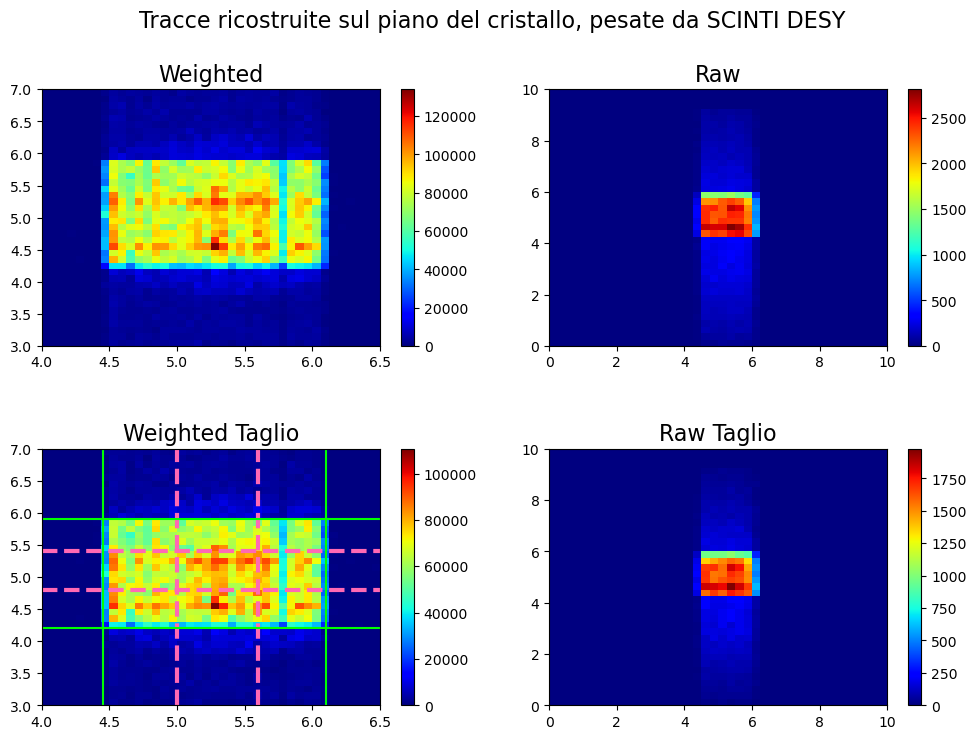

In [6]:
### SEARCH THE CRYSTAL ON SCINTI DESY (usefull for thick crytsal alignement on mutiplicity [and Auto Trigger open])###
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,8)
fig.subplots_adjust(hspace=.4)
fig.suptitle(f"Tracce ricostruite sul piano del cristallo, pesate da SCINTI DESY", fontsize = 16)
ax = ax.flatten()

hh = ax[0].hist2d(x2, y2, bins = 40, weights = ph_scinti_desy,
                range = ((4,6.5),(3,7)),cmap = mycmap)
                # range = ((4,7),(3,7)),norm = mpl.colors.LogNorm(), cmap = mycmap)
                # range = ((0,10),(0,10)),norm = mpl.colors.LogNorm(), cmap = mycmap)
fig.colorbar(hh[3], ax = ax[0])

hh = ax[1].hist2d(x2, y2, bins = 40, 
                range = ((0,10),(0,10)), cmap = mycmap)
                # range = ((0,10),(0,10)),norm = mpl.colors.LogNorm(), cmap = mycmap)
fig.colorbar(hh[3], ax = ax[1])

ax[0].set_title("Weighted", fontsize = 16)
ax[1].set_title("Raw", fontsize = 16)

# logi_taglio = logi_cherry & (Scinti_after_magnet > 40)
logi_taglio = logi_cherry # & (Calo_elect1 > 80) #(Calo_photon < 40) & 

hh = ax[2].hist2d(x2[logi_taglio], y2[logi_taglio], bins = 40, weights = ph_scinti_desy[logi_taglio],
                range = ((4,6.5),(3,7)), cmap = mycmap)
                # range = ((4,7),(3,7)),norm = mpl.colors.LogNorm(), cmap = mycmap)
                # range = ((0,10),(0,10)), cmap = mycmap)
fig.colorbar(hh[3], ax = ax[2])

hh = ax[3].hist2d(x2[logi_taglio], y2[logi_taglio], bins = 40, 
                # range = ((4,7),(3,7)),norm = mpl.colors.LogNorm(), cmap = mycmap)
                range = ((0,10),(0,10)), cmap = mycmap)
fig.colorbar(hh[3], ax = ax[3])
ax[2].set_title("Weighted Taglio", fontsize = 16)
ax[3].set_title("Raw Taglio", fontsize = 16)

#### add lines of cut and autotrigger##
ax[2].axvline(x = pos_cut_x[0], ls = "--", lw = 3, c = "hotpink")
ax[2].axvline(x = pos_cut_x[1], ls = "--", lw = 3, c = "hotpink")
ax[2].axhline(y = pos_cut_y[0], ls = "--", lw = 3, c = "hotpink")
ax[2].axhline(y = pos_cut_y[1], ls = "--", lw = 3, c = "hotpink")

x_c_min_at ,x_c_max_at, y_c_min_at, y_c_max_at = 4.45,6.1,4.2,5.90

ax[2].axvline(x_c_min_at, color='lime')
ax[2].axvline(x_c_max_at, color='lime')
ax[2].axhline(y_c_min_at, color='lime') 
ax[2].axhline(y_c_max_at, color='lime') 

plt.show()

# Pulseheight and signals of each channel

(135090,)
(135090,)


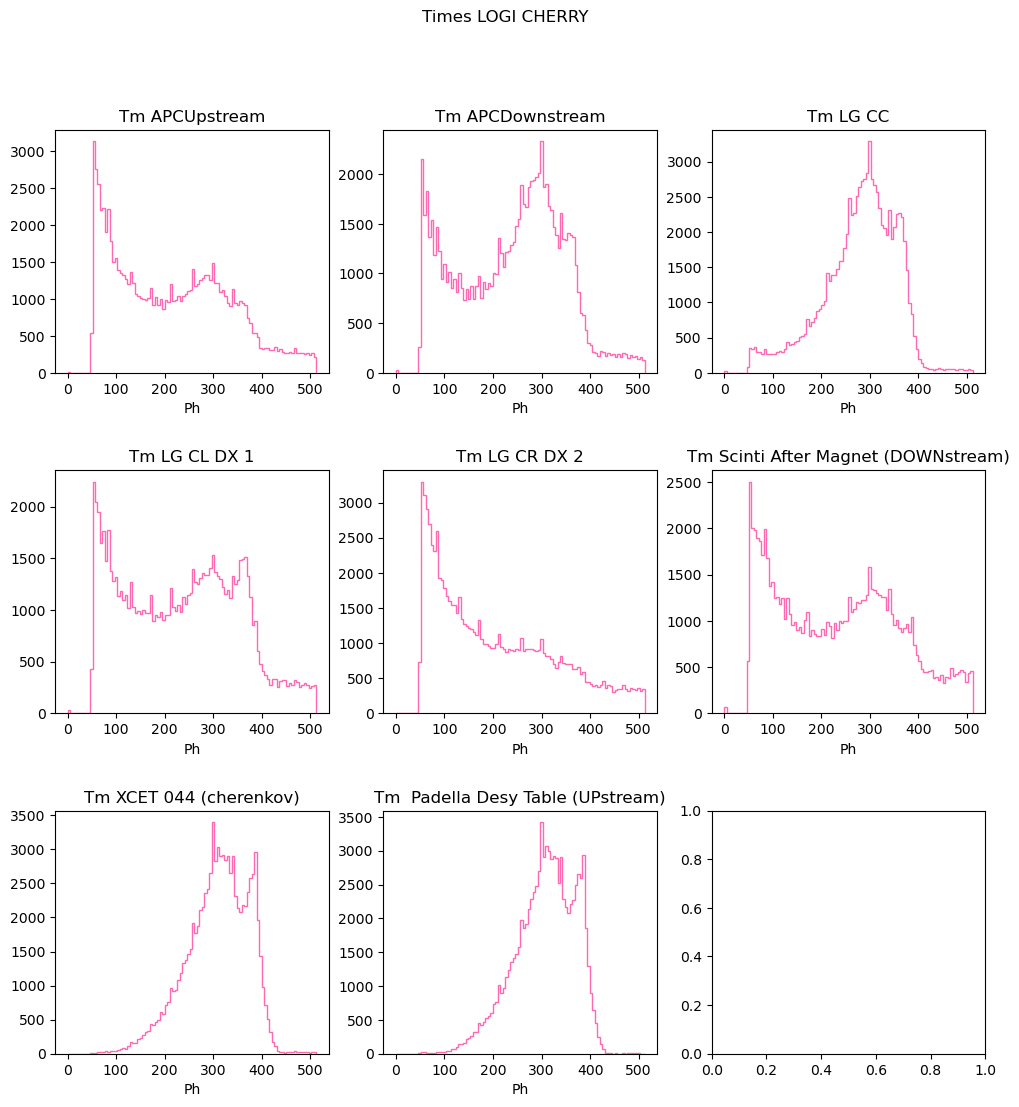

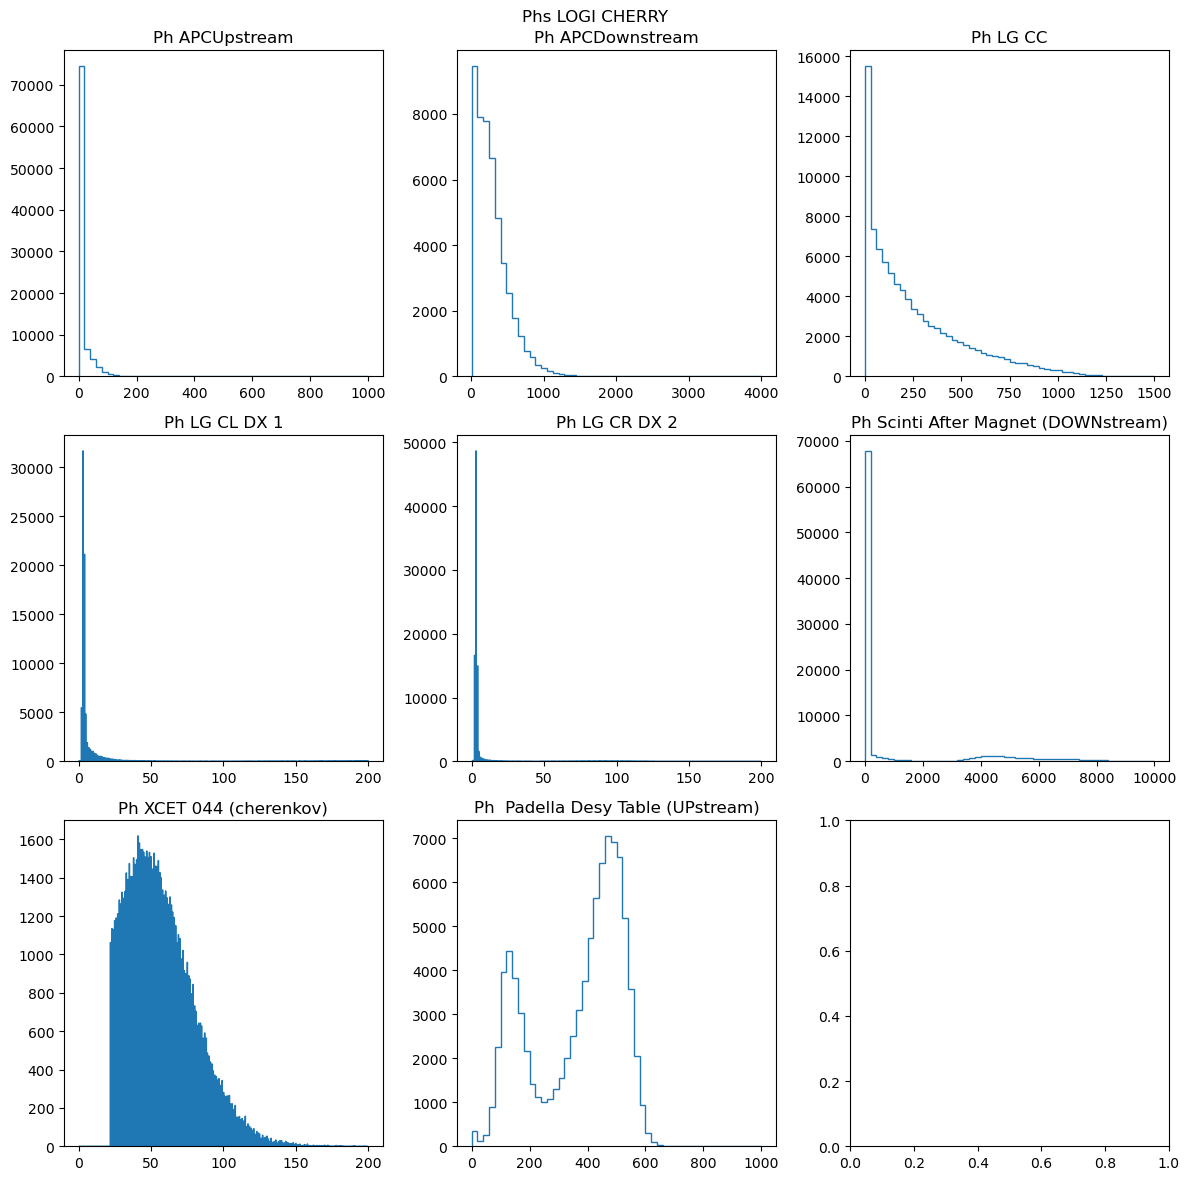

In [7]:
labels = [ 'APCUpstream','APCDownstream', 'LG CC', 'LG CL DX 1','LG CR DX 2', 'Scinti After Magnet (DOWNstream)','XCET 044 (cherenkov)',' Padella Desy Table (UPstream)'] #atm hardcoded, will be on dictionary
opts = {"histtype": 'step'}
fig, ax = plt.subplots(3,3) ##atm hardcoded
fig.set_size_inches(12,12)
fig.subplots_adjust(hspace=.4)
fig.suptitle('Times LOGI CHERRY')

## debug to check if logi is ok --> has to be the same lenght ##
print(np.shape(tm[:,0]))
print(np.shape(logi_cherry))


######## TIMES ###########
for ch in range(0,8):
    ax = ax.flatten()
    h = ax[ch].hist(tm[:,ch][logi_cherry],bins=100, range=(0,512), label= labels[ch],color="hotpink", **opts )
    ax[ch].set_title(f'Tm {labels[ch]}')
    ax[ch].set_xlabel(f'1 tick = 10 ns')

######## PHS ###########
fig1, ax1 = plt.subplots(3,3)
fig1.set_size_inches(12,12)
fig1.subplots_adjust(hspace=.4)
fig1.suptitle('Phs LOGI CHERRY')

##here the range is different so some tricks

for ch in range(0,8):
    ax1 = ax1.flatten()
    if ch in (0,7):
        h = ax1[ch].hist(ph[:,ch][logi_cherry],bins=50, range=(0,1000), label= labels[ch],fc="tab:green",**opts )
    elif ch in (3,4,6):
        h = ax1[ch].hist(ph[:,ch][logi_cherry],bins=750, range=(0,200), label= labels[ch],fc="tab:green",**opts )
    elif ch == 5:
        h = ax1[ch].hist(ph[:,ch][logi_cherry],bins=50, range=(0,10000), label= labels[ch],fc="tab:green",**opts )
    elif ch == 1:
        h = ax1[ch].hist(ph[:,ch][logi_cherry],bins=50, range=(10,4000), label= labels[ch],fc="tab:green",**opts )
    else:
        h = ax1[ch].hist(ph[:,ch][logi_cherry],bins=50, range=(0,1500), label= labels[ch],fc="tab:green",**opts )
    
    ax1[ch].set_title(f'Ph {labels[ch]}')
    # ax1[ch].set_yscale('log')
    ax[ch].set_xlabel(f'Ph')
    
## one can add the threshold line
    # ax1[ch].axvline(x = 50)

plt.tight_layout()
plt.show()

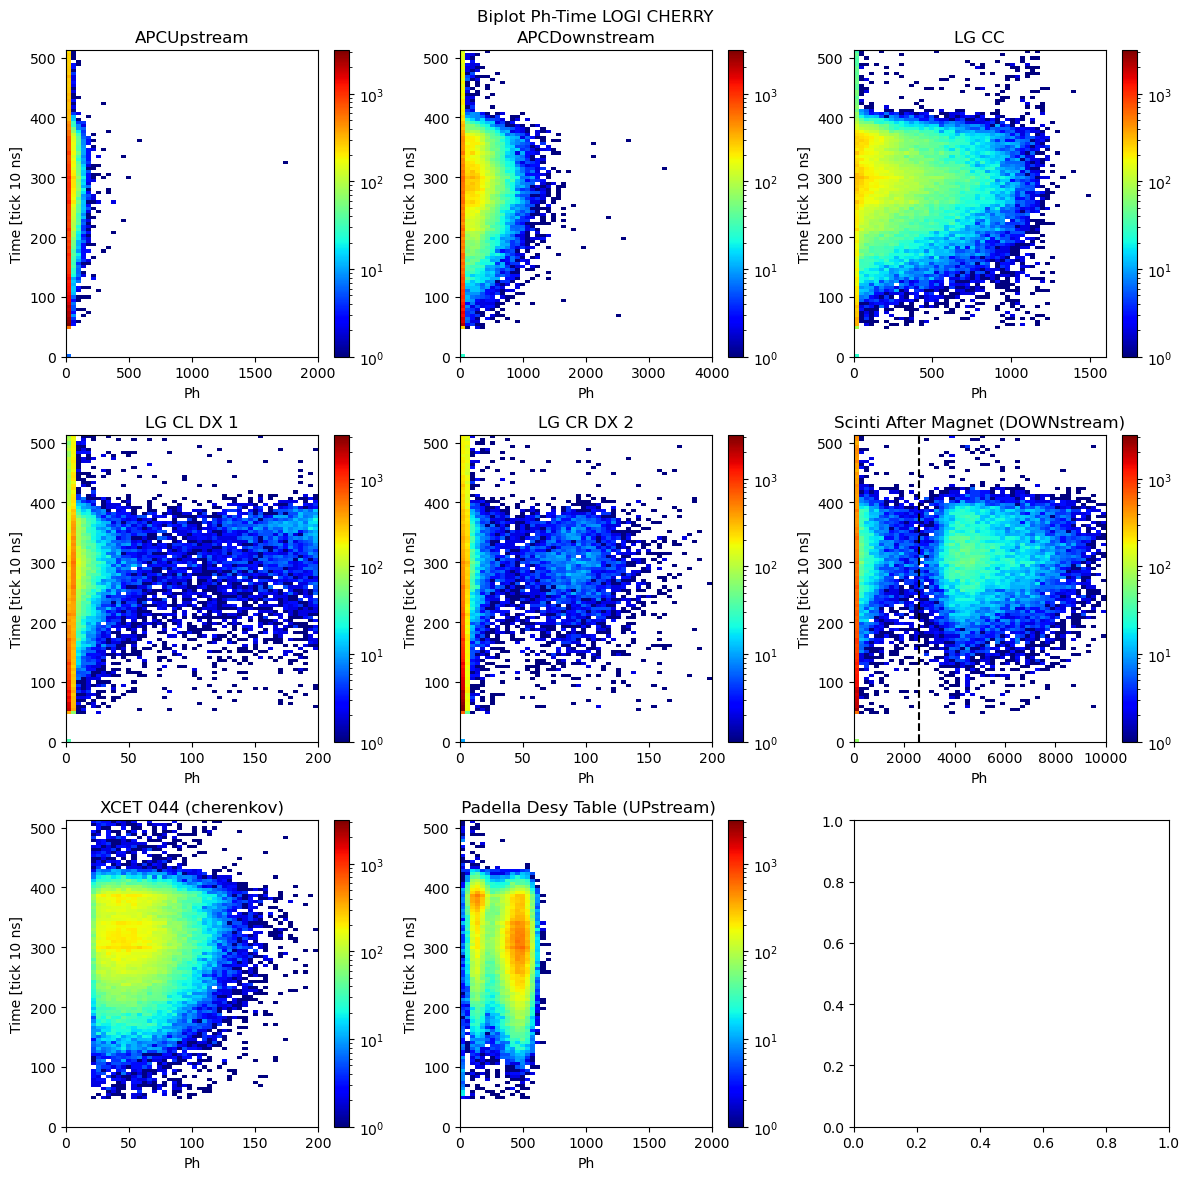

In [8]:
##### 2d plot of ph vs tm [LOGI CHERRY] #####
opts_2d = { "cmap" : mycmap, "bins" : [50,100], "norm" : mpl.colors.LogNorm()}
opt_axlines = { "c" : 'k', "ls" : '--'}
fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,12)
fig.suptitle('Biplot Ph-Time LOGI CHERRY')

for ch in range(0,8):
    ax = ax.flatten()
    if ch in (0,7):
        hh = ax[ch].hist2d(ph[:,ch][logi_cherry],tm[:,ch][logi_cherry], range=((0,2000),(0,512)), label= labels[ch], **opts_2d)
    elif ch in (3,4,6):
        hh = ax[ch].hist2d(ph[:,ch][logi_cherry],tm[:,ch][logi_cherry], range=((0,200),(0,512)), label= labels[ch], **opts_2d)
    elif ch == 5:
        hh = ax[ch].hist2d(ph[:,ch][logi_cherry],tm[:,ch][logi_cherry], range=((0,10000),(0,512)), label= labels[ch], **opts_2d)
    elif ch == 1:
        hh = ax[ch].hist2d(ph[:,ch][logi_cherry],tm[:,ch][logi_cherry], range=((0,4000),(0,512)), label= labels[ch], **opts_2d)
    else:
        hh = ax[ch].hist2d(ph[:,ch][logi_cherry],tm[:,ch][logi_cherry], range=((0,1600),(0,512)), label= labels[ch], **opts_2d)
    ax[ch].set_title(f'{labels[ch]}')
    ax[ch].set_ylabel(f'Time [tick 10 ns]')
    ax[ch].set_xlabel(f'Ph')
    
    fig.colorbar(hh[3], ax = ax[ch])    

ax[5].axvline(x = th_scinti_magnet, **opt_axlines)

plt.tight_layout()
plt.show()


In [9]:
count_tot = np.shape(ph[:,5])[0]
count_cherry = np.shape(ph[:,5][logi_cherry])[0]
cout_end = np.shape(ph[:,5][(logi_cherry) &(ph[:,5]>th_scinti_magnet)])[0]

print(count_tot,count_cherry,cout_end)
print(f'survival cherry {100*(count_cherry/count_tot):.2f} % - survival Canadese {100*(cout_end/count_tot):.2f} %')
print(f'percentage electron survived cut {100*(cout_end/count_cherry):.2f} %')

135090 89622 17105
survival cherry 66.34 % - survival Canadese 12.66 %
percentage electron survived cut 19.09 %


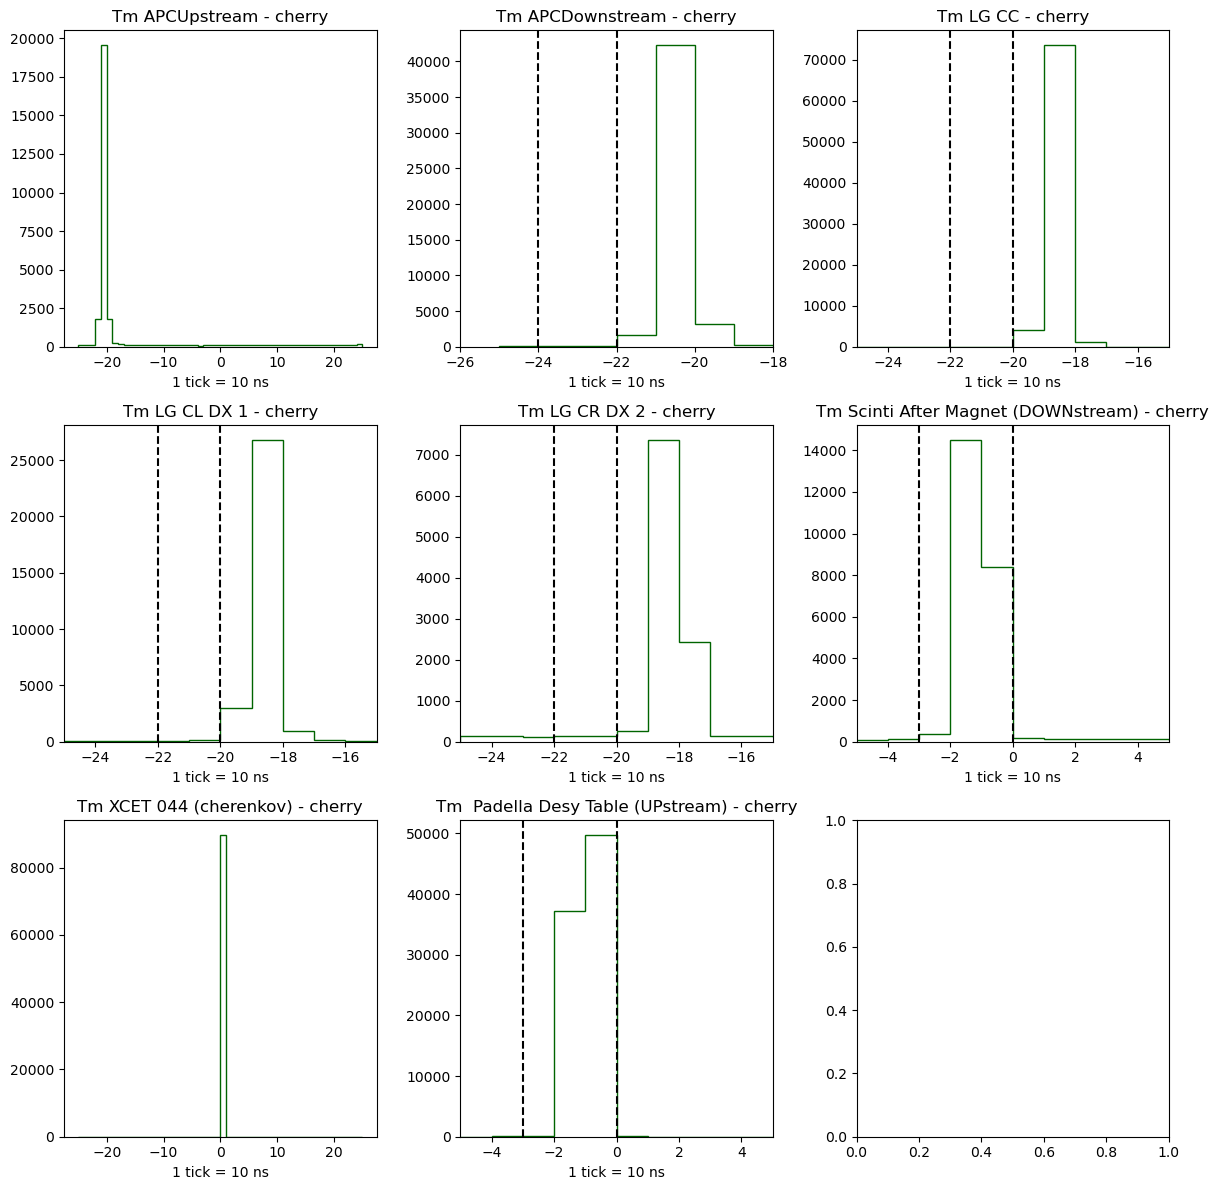

In [10]:
### 1 D
opts = {"bins": 50, "color" : 'darkgreen', "histtype": 'step'} 
fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,12)

for ch in range(0,8):
    ax = ax.flatten()
    h = ax[ch].hist((tm[:,ch]-tm[:,6])[logi_cherry],range=(-25,25), label= labels[ch] + f' ch{ch}', **opts)
    ax[ch].set_title(f'Tm {labels[ch]} - cherry')
    ax[ch].set_xlabel(f'1 tick = 10 ns')

##SET LINES FOR CHECK THE TIME THRESHOLDS
for ch in (5,7): ## PAD DESY and SCINTI Mag
    ax[ch].axvline(x = 0, **opt_axlines)
    ax[ch].axvline(x = -3, **opt_axlines)
    ax[ch].set_xlim(-5,5)
ch = 1
ax[ch].axvline(x = -24, **opt_axlines)
ax[ch].axvline(x = -22, **opt_axlines)
ax[ch].set_xlim(-26,-18)
for ch in (2,3,4):
    ax[ch].axvline(x = -20, **opt_axlines)
    ax[ch].axvline(x = -22, **opt_axlines)
    ax[ch].set_xlim(-25,-15)
plt.tight_layout()
plt.show()

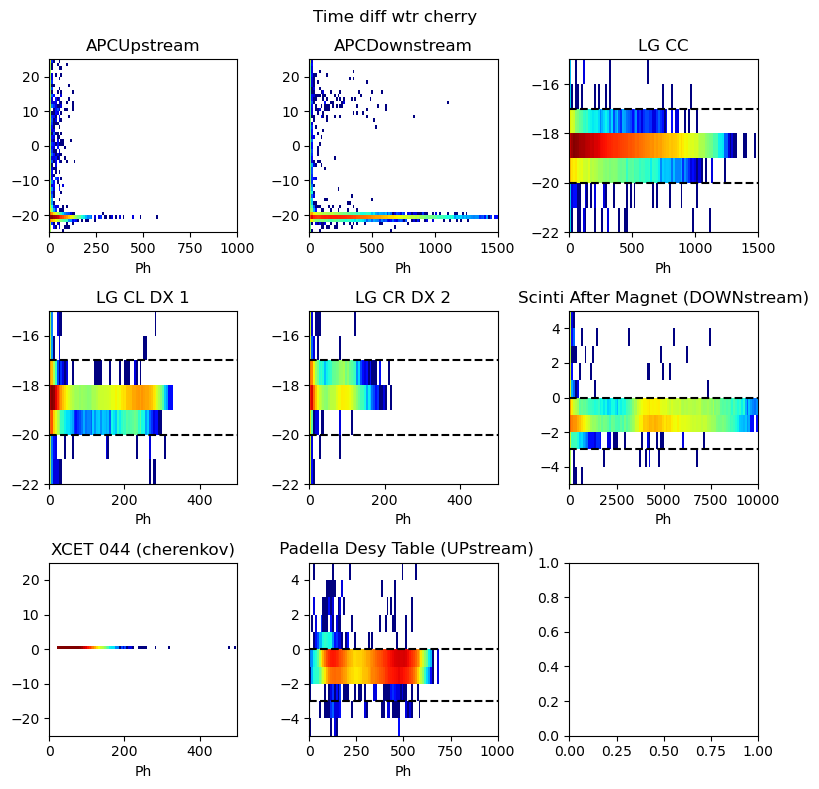

In [11]:
opts_2d = {"bins": (100,50), "lw" : 2,"cmap" : mycmap, "norm" : mpl.colors.LogNorm()} 
fig, ax = plt.subplots(3,3)
fig.set_size_inches(8,8)
fig.suptitle('Time diff wtr cherry') 

for ch in range(0,8):
    ax = ax.flatten()
    if ch in (0,7):
        hh = ax[ch].hist2d(ph[:,ch][logi_cherry],(tm[:,ch]-tm[:,6])[logi_cherry], range=((0,1000),(-25,25)), label= labels[ch], **opts_2d)   
    elif ch in (3,4,6): ## LG DX, LG DXDX, cherry 
        hh = ax[ch].hist2d(ph[:,ch][logi_cherry],(tm[:,ch]-tm[:,6])[logi_cherry], range=((0,500),(-25,25)), label= labels[ch], **opts_2d)
    elif ch == 5: ## Canadese Photon
        hh = ax[ch].hist2d(ph[:,ch][logi_cherry],(tm[:,ch]-tm[:,6])[logi_cherry], range=((0,10000),(-25,25)), label= labels[ch], **opts_2d)
        
    else:
        hh = ax[ch].hist2d(ph[:,ch][logi_cherry],(tm[:,ch]-tm[:,6])[logi_cherry], range=((0,1500),(-25,25)), label= labels[ch], **opts_2d)
    
    ax[ch].set_title(f'{labels[ch]}')
    ax[ch].set_xlabel(f'Time diff ch - cherry')
    ax[ch].set_xlabel(f'Ph')


##SET LINES FOR CHECK THE TIME THRESHOLDS
for ch in (5,7): ## PAD DESY and SCINTI Mag
    ax[ch].axhline(y = 0, **opt_axlines)
    ax[ch].axhline(y = -3, **opt_axlines)
    ax[ch].set_ylim(-5,5)
for ch in (2,3,4):
    ax[ch].axhline(y = -20, **opt_axlines)
    ax[ch].axhline(y = -17, **opt_axlines)
    ax[ch].set_ylim(-22,-15)

plt.tight_layout()
plt.show()

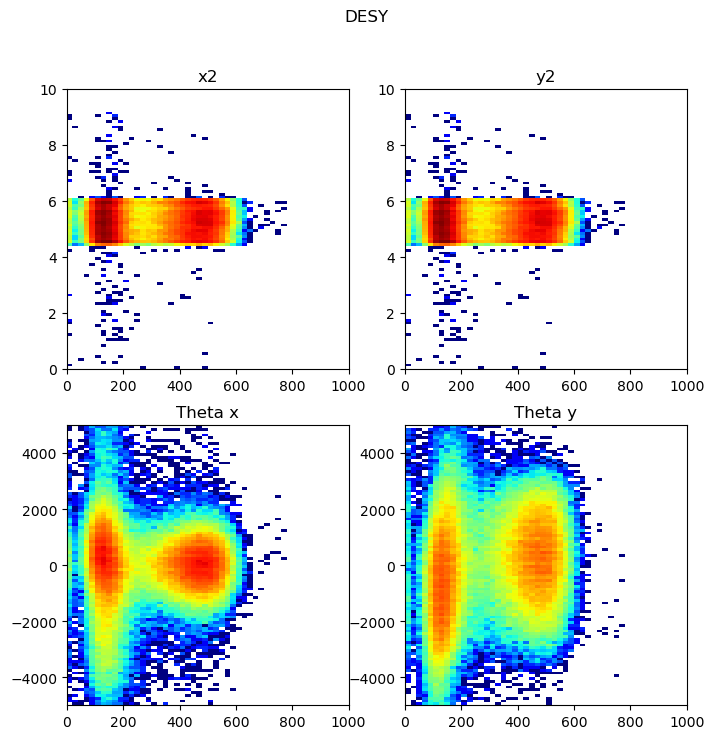

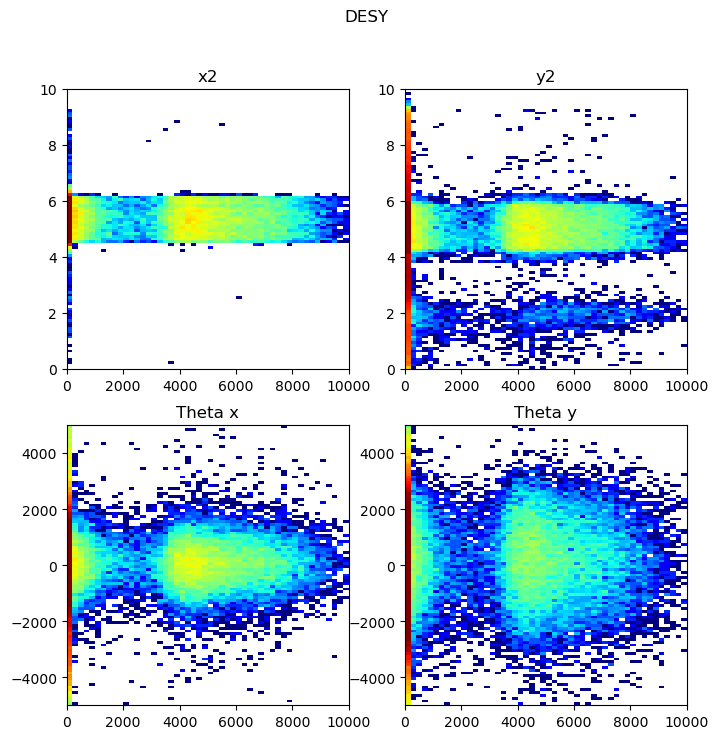

In [12]:
opts_2d = { "cmap" : mycmap, "bins" : [50,100], "norm" : mpl.colors.LogNorm()}
opt_axlines = { "c" : 'r', "ls" : '--', "lw" : 2}

##### DESY #####
fig, ax = plt.subplots(2,2)
fig.set_size_inches(8,8)
fig.suptitle('DESY')
ax = ax.flatten()

logi_ph_positron = (ph_scinti_after_magnet > th_scinti_magnet)
logi_3 = (logi_cherry) & (logi_ph_positron)

Con_taglio = False

if Con_taglio:
    ax[0].hist2d(ph_scinti_desy[logi_3],x_cry[logi_3], range=((0,1000),(0,10)), **opts_2d)
    ax[1].hist2d(ph_scinti_desy[logi_3],y_cry[logi_3], range=((0,1000),(0,10)), **opts_2d )
    ax[2].hist2d(ph_scinti_desy[logi_3],theta_in_x[logi_3], range=((0,1000),(-5000,5000)), **opts_2d )
    ax[3].hist2d(ph_scinti_desy[logi_3],theta_in_y[logi_3], range=((0,1000),(-5000,5000)), **opts_2d )
else:
    ax[0].hist2d(ph_scinti_desy,x2, range=((0,1000),(0,10)), **opts_2d )
    ax[1].hist2d(ph_scinti_desy,x2, range=((0,1000),(0,10)), **opts_2d )
    ax[2].hist2d(ph_scinti_desy,theta_in_x, range=((0,1000),(-5000,5000)), **opts_2d )
    ax[3].hist2d(ph_scinti_desy,theta_in_y, range=((0,1000),(-5000,5000)), **opts_2d )

ax[0].set_title('x2')
ax[1].set_title('y2')
ax[2].set_title('Theta x')
ax[3].set_title('Theta y')
plt.show()


##### SCINTI #####
fig2, ax2 = plt.subplots(2,2)
fig2.set_size_inches(8,8)
fig2.suptitle('DESY')
ax2 = ax2.flatten()

logi_ph_positron = (ph_scinti_after_magnet > th_scinti_magnet)
logi_3 = (logi_cherry) & (logi_ph_positron)

Con_taglio = False

if Con_taglio:
    ax2[0].hist2d(ph_scinti_after_magnet[logi_3],x2[logi_3], range=((0,10000),(0,10)), **opts_2d)
    ax2[1].hist2d(ph_scinti_after_magnet[logi_3],x2[logi_3], range=((0,10000),(0,10)), **opts_2d )
    ax2[2].hist2d(ph_scinti_after_magnet[logi_3],theta_in_x[logi_3], range=((0,10000),(-5000,5000)), **opts_2d )
    ax2[3].hist2d(ph_scinti_after_magnet[logi_3],theta_in_y[logi_3], range=((0,10000),(-5000,5000)), **opts_2d )
else:
    ax2[0].hist2d(ph_scinti_after_magnet,x_cry, range=((0,10000),(0,10)), **opts_2d )
    ax2[1].hist2d(ph_scinti_after_magnet,y_cry, range=((0,10000),(0,10)), **opts_2d )
    ax2[2].hist2d(ph_scinti_after_magnet,theta_in_x, range=((0,10000),(-5000,5000)), **opts_2d )
    ax2[3].hist2d(ph_scinti_after_magnet,theta_in_y, range=((0,10000),(-5000,5000)), **opts_2d )

ax2[0].set_title('x2')
ax2[1].set_title('y2')
ax2[2].set_title('Theta x')
ax2[3].set_title('Theta y')
plt.show()


/tmp/ipykernel_2749/2652204513.py:16: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 9 Axes> than <Figure size 1200x600 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(hh[3], ax = ax[0])
/tmp/ipykernel_2749/2652204513.py:28: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 9 Axes> than <Figure size 1200x600 with 4 Axes> which fig.colorbar is called on.
  fig.colorbar(hh[3], ax = ax[1])


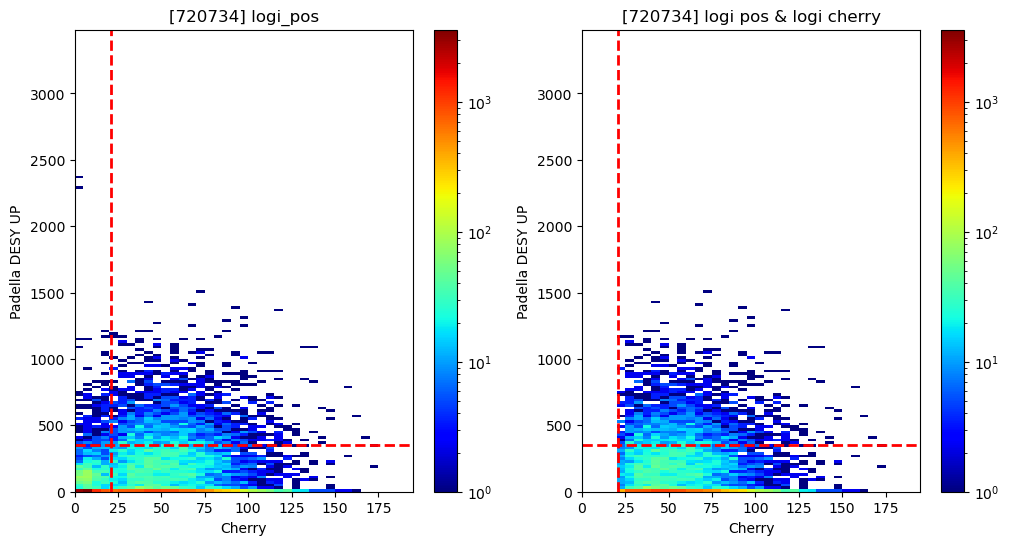

In [13]:
# opts_2d = {"bins": (np.arange(0,200,5),np.arange(0,1000,10)), "lw" : 2,"cmap" : mycmap, "norm" : mpl.colors.LogNorm()} 
opts_2d = {"bins": (np.arange(0,200,5),np.arange(0,3500,20)), "lw" : 2,"cmap" : mycmap, "norm" : mpl.colors.LogNorm()} 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
# logi_time = (tm[:,7]-tm[:,6] < 2.5) & (tm[:,7]-tm[:,6] > -2.5)
# logi = (logi_cherry) #& (logi_ph_positron)
logi = (logi_pos) #& (logi_ph_positron)

# hh1 = ax[0].hist2d(ph_cherry1[logi],ph_scinti_desy[logi],**opts_2d)
hh1 = ax[0].hist2d(ph_cherry1[logi],ph_apc2[logi],**opts_2d)
ax[0].set_title(f'{run} logi_pos')
ax[0].set_xlabel(f'Cherry')
ax[0].set_ylabel(f'Padella DESY UP')
ax[0].axvline(x=th_cherry, **opt_axlines)
ax[0].axhline(y=th_scinti_desy, **opt_axlines )
fig.colorbar(hh[3], ax = ax[0])

logi_cherry = ph_cherry1 > 21
logi = (logi_pos) & (logi_cherry)

# hh2 = ax[1].hist2d(ph_cherry1[logi],ph_scinti_desy[logi],**opts_2d)
hh2 = ax[1].hist2d(ph_cherry1[logi],ph_apc2[logi],**opts_2d)
ax[1].set_title(f'{run} logi pos & logi cherry')
ax[1].set_xlabel(f'Cherry')
ax[1].set_ylabel(f'Padella DESY UP')
ax[1].axvline(x=th_cherry, **opt_axlines)
ax[1].axhline(y=th_scinti_desy, **opt_axlines)
fig.colorbar(hh[3], ax = ax[1])

plt.show()


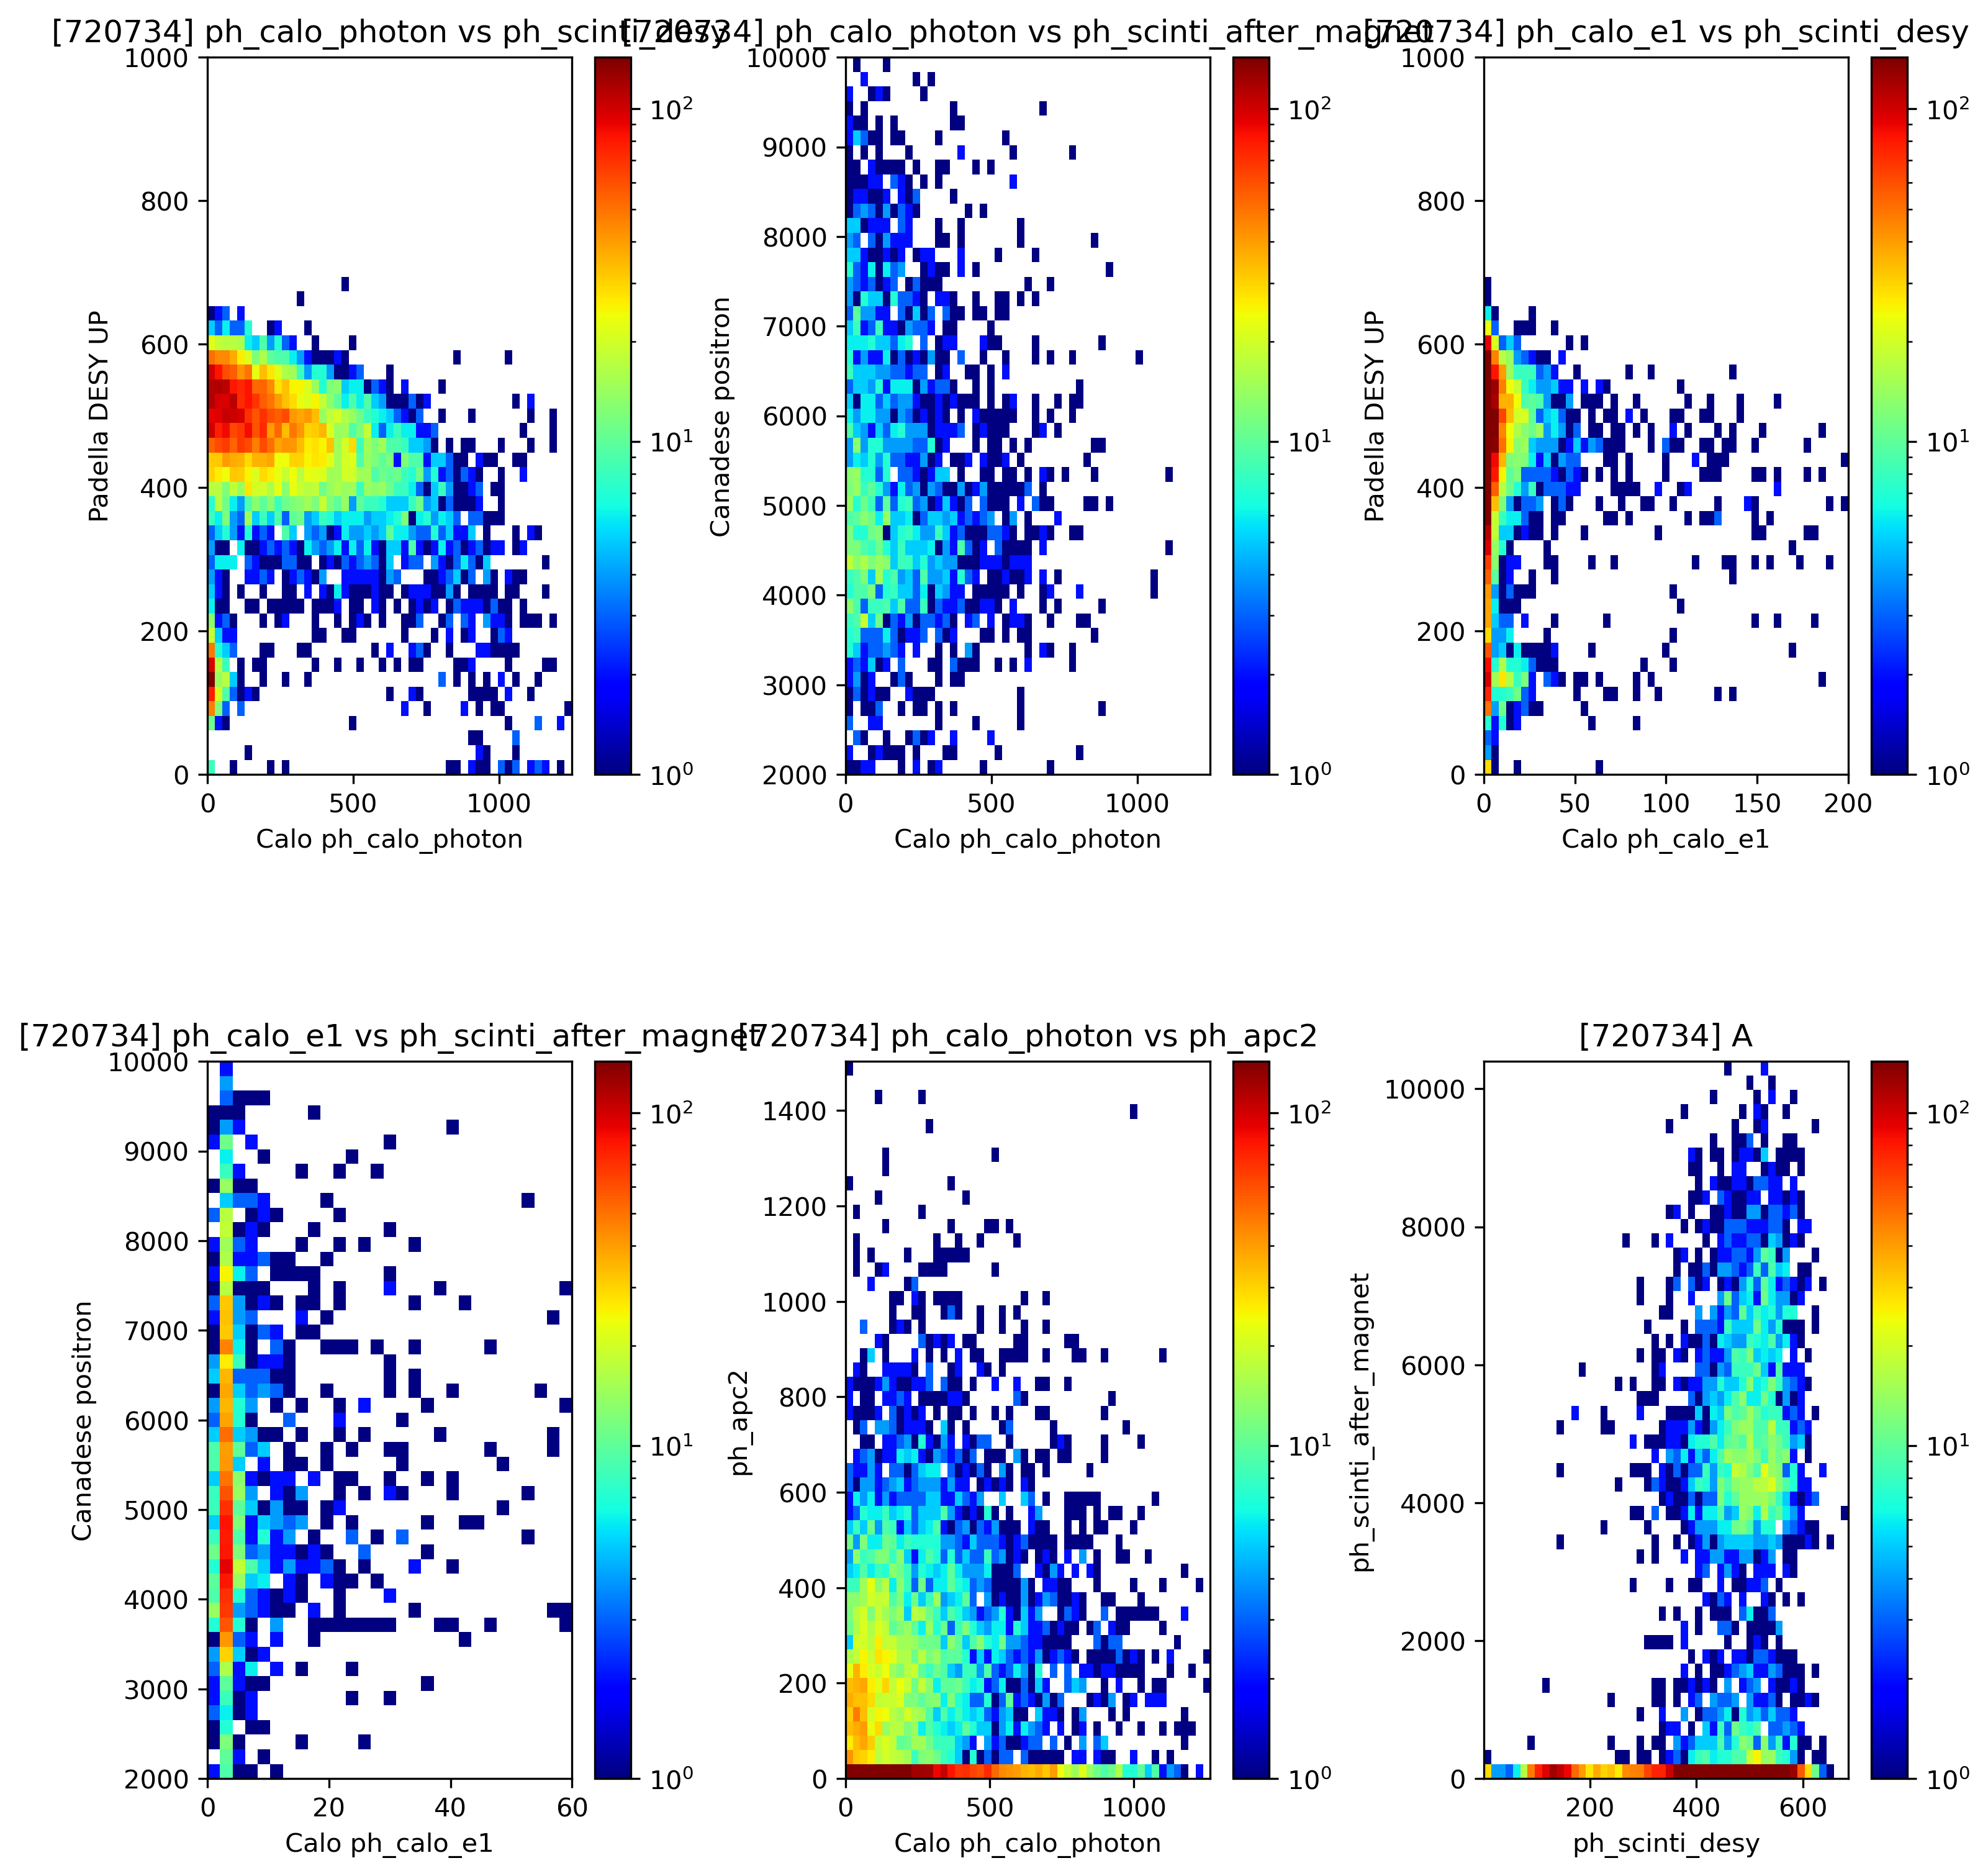

In [14]:
opts_2d = {"lw" : 2,"cmap" : mycmap, "norm" : mpl.colors.LogNorm()} 
fig, ax = plt.subplots(2,3, dpi = 300)
fig.set_size_inches(12,12)
fig.subplots_adjust(hspace = .4, wspace = .4)
ax = ax.flatten()
# logi_time = (tm[:,7]-tm[:,6] < 2.5) & (tm[:,7]-tm[:,6] > -2.5)
# logi = (logi_cherry) #& (logi_ph_positron)

logi = (logi_pos) & (logi_cherry)

hh1 = ax[0].hist2d(ph_calo_photon[logi],ph_scinti_desy[logi],bins=  (np.linspace(0,1250,50),np.linspace(0,1000,50)),**opts_2d)
ax[0].set_title(f'{run} ph_calo_photon vs ph_scinti_desy')
ax[0].set_xlabel(f'Calo ph_calo_photon')
ax[0].set_ylabel(f'Padella DESY UP')
fig.colorbar(hh1[3], ax = ax[0])

hh2 = ax[1].hist2d(ph_calo_photon[logi],ph_scinti_after_magnet[logi],bins=  (np.linspace(0,1250,50),np.linspace(2000,10000,50)),**opts_2d)
ax[1].set_title(f'{run} ph_calo_photon vs ph_scinti_after_magnet')
ax[1].set_xlabel(f'Calo ph_calo_photon')
ax[1].set_ylabel(f'Canadese positron')
# ax[1].axvline(x=th_cherry, **opt_axlines)
# ax[1].axhline(y=th_scinti_desy, **opt_axlines)
fig.colorbar(hh2[3], ax = ax[1])

hh3 = ax[2].hist2d(ph_calo_elect1[logi],ph_scinti_desy[logi],bins=  (np.linspace(0,200,50),np.linspace(0,1000,50)),**opts_2d)
ax[2].set_title(f'{run} ph_calo_e1 vs ph_scinti_desy')
ax[2].set_xlabel(f'Calo ph_calo_e1')
ax[2].set_ylabel(f'Padella DESY UP')
fig.colorbar(hh3[3], ax = ax[2])

hh4 = ax[3].hist2d(ph_calo_elect1[logi],ph_scinti_after_magnet[logi],bins=  (np.linspace(0,60,30),np.linspace(2000,10000,50)),**opts_2d)
ax[3].set_title(f'{run} ph_calo_e1 vs ph_scinti_after_magnet')
ax[3].set_xlabel(f'Calo ph_calo_e1')
ax[3].set_ylabel(f'Canadese positron')
fig.colorbar(hh4[3], ax = ax[3])

# hh5 = ax[4].hist2d(ph_calo_photon[logi],ph_calo_elect1[logi],bins=  (np.linspace(0,1250,50),np.linspace(0,60,30)),**opts_2d)
hh5 = ax[4].hist2d(ph_calo_photon[logi],ph_apc2[logi],bins=  50,**opts_2d)
ax[4].set_title(f'{run} ph_calo_photon vs ph_apc2')
ax[4].set_xlabel(f'Calo ph_calo_photon')
ax[4].set_ylabel(f'ph_apc2')
fig.colorbar(hh5[3], ax = ax[4])

# hh6 = ax[5].hist2d(ph_calo_photon[logi],ph_calo_elect2[logi],bins=  (np.linspace(0,1250,50),np.linspace(0,60,30)),**opts_2d)
hh6 = ax[5].hist2d(ph_scinti_desy[logi],ph_scinti_after_magnet[logi],bins=  50,**opts_2d)
ax[5].set_title(f'{run} A')
ax[5].set_xlabel(f'ph_scinti_desy')
ax[5].set_ylabel(f'ph_scinti_after_magnet')
fig.colorbar(hh6[3], ax = ax[5])



plt.show()


In [15]:
errore

NameError: name 'errore' is not defined

In [ ]:
### plot of calorimeters and scinti after magnet to check radiation and positron deposit on and off crystal
nbins = 50
opts = { "density": True, "histtype" : 'step', "bins": nbins, "lw" : 2} 

logi_extra = logi_cherry ## one can add something here 

logi_oncryst = logi_pos & logi_extra
logi_offcryst = np.logical_not(logi_oncryst) & logi_extra


### calculation of the mean values ###
mean_ph_oncrys  = np.mean(ph_calo_photon[logi_oncryst & logi_time_calo_ph])
mean_ph_offcrys = np.mean(ph_calo_photon[logi_offcryst & logi_time_calo_ph])

mean_e1_oncrys  = np.mean(ph_calo_elect1[logi_oncryst & logi_time_el1])
mean_e1_offcrys  = np.mean(ph_calo_elect1[logi_offcryst & logi_time_el1])

mean_pad_oncrys  = np.mean(ph_scinti_after_magnet[logi_oncryst & logi_time_pad])
mean_pad_offcrys  = np.mean(ph_scinti_after_magnet[logi_offcryst & logi_time_pad])

    
fig, ax = plt.subplots(3)
fig.set_size_inches(8,12)
fig.subplots_adjust(hspace=.4)
ax = ax.flatten()
## CUT ON CRYSTAL
h_ph_oncrys = ax[0].hist(ph_calo_photon[logi_oncryst & logi_time_calo_ph], range = (0,1500), label=f'Calo CC on-crys {mean_ph_oncrys:.2f}' , **opts)
h_e1_oncrys = ax[1].hist(ph_calo_elect1[logi_oncryst & logi_time_el1], range = (0,100), label=f'Calo DX on-crys {mean_e1_oncrys:.2f}' , **opts)
h_pad_oncrys = ax[2].hist(ph_scinti_after_magnet[logi_oncryst & logi_time_pad], range =(0,10000),   label=f'Pad DW on-crys {mean_pad_oncrys:.2f}' , **opts)

binc_h_ph_on = h_ph_oncrys[1][:-1] + (h_ph_oncrys[1][1] - h_ph_oncrys[1][0]) / 2
binc_h_e1_on = h_e1_oncrys[1][:-1] + (h_e1_oncrys[1][1] - h_e1_oncrys[1][0]) / 2
binc_h_pad_on = h_pad_oncrys[1][:-1] + (h_pad_oncrys[1][1] - h_pad_oncrys[1][0]) / 2

## CUT OUT CRYSTAL
h_ph_offcrys = ax[0].hist(ph_calo_photon[logi_offcryst & logi_time_calo_ph], range = (0,1500),ls = '--', label=f'Calo CC off-crys {mean_ph_offcrys:.2f}', **opts )
h_e1_offcrys = ax[1].hist(ph_calo_elect1[logi_offcryst & logi_time_el1], range =(0,100),  ls = '--', label=f'Calo DX off-crys {mean_e1_offcrys:.2f}', **opts)
h_pad_offcrys = ax[2].hist(ph_scinti_after_magnet[logi_offcryst & logi_time_pad], range =(0,10000),  ls = '--', label=f'Pad Dw off-crys {mean_pad_offcrys:.2f}' , **opts)

binc_h_ph_off = h_ph_offcrys[1][:-1] + (h_ph_offcrys[1][1] - h_ph_offcrys[1][0]) / 2
binc_h_e1_off = h_e1_offcrys[1][:-1] + (h_e1_offcrys[1][1] - h_e1_offcrys[1][0]) / 2
binc_h_pad_off = h_pad_offcrys[1][:-1] + (h_pad_offcrys[1][1] - h_pad_offcrys[1][0]) / 2


result_ph_oncrys = h_ph_oncrys[0] * binc_h_ph_on
result_e1_oncrys = h_e1_oncrys[0] * binc_h_e1_on
result_pad_oncrys = h_pad_oncrys[0] * binc_h_pad_on
    
result_ph_offcrys = h_ph_offcrys[0] * binc_h_ph_off
result_e1_offcrys = h_e1_offcrys[0] * binc_h_e1_off
result_pad_offcrys = h_pad_offcrys[0] * binc_h_pad_off

ax[0].legend()
ax[0].set_title('Calo CC - photons')
ax[0].set_yscale('log')
ax[1].legend()
ax[1].set_title('Calo DX - electrons')
ax[1].set_yscale('log')
ax[2].legend()
ax[2].set_title('Pad Down - positrons')
ax[2].set_yscale('log')

plt.show()
print(' mean ratio ON/OFF : PH {mean_ph_oncrys/mean_ph_offcrys:.2f} E1 {mean_e1_oncrys/mean_e1_offcrys:.2f} PAD {mean_pad_oncrys/mean_pad_offcrys:.2f}')
print(f' tot signal ratio ON/OFF : PH {np.sum(result_ph_oncrys)/np.sum(result_ph_offcrys):.2f} E1 {np.sum(result_e1_oncrys)/np.sum(result_e1_offcrys):.2f} PAD {np.sum(result_pad_oncrys)/np.sum(result_pad_offcrys):.2f}')


In [ ]:
error

In [ ]:
def myProfile(xVect, yVect, nbin):
    h, bins = np.histogram(xVect, bins = nbin)
    binc = bins[:-1] + (bins[1]- bins[0])/2
    
    out_vect = np.array([np.mean(yVect[(xVect >= bins[i]) & (xVect < bins[i+1])]) for i in range(nbin)])
    out_err =  np.array([np.std (yVect[(xVect >= bins[i]) & (xVect < bins[i+1])]) for i in range(nbin)])
    
    return binc, out_vect, out_err

def Histo2DProfile_ax(xVect, yVect, nbinx, nbiny, rangex, rangey,ax,trigger_level, **kwargs):
    
    # fig, ax = plt.subplots()
    # fig.set_size_inches(11, 6)

    # Hist 2d
    mat, binsx, binsy, hh = ax.hist2d(xVect, yVect, bins = (nbinx, nbiny), range = (rangex, rangey), **kwargs)
    
    
    # Plug here the old function
    h, bins = np.histogram(xVect, bins = nbinx, range = rangex)
    binc = bins[:-1] + (bins[1]- bins[0])/2
    
    log = (yVect >= rangey[0]) & (yVect <= rangey[1])
    xVect = xVect[log]
    yVect = yVect[log]
    
    out_vect = np.array([np.nanmean(yVect[(xVect >= bins[i]) & (xVect < bins[i+1])]) for i in range(nbinx)])
    out_err =  np.array([np.nanstd (yVect[(xVect >= bins[i]) & (xVect < bins[i+1])]) for i in range(nbinx)])
    
    # Plot profile plot
    ax.errorbar(binc, out_vect, yerr = out_err, ls = ":", c = "hotpink", marker = ".")
    fig.colorbar(hh, ax = ax)
    
    # Apply trigger condition based on percentage difference
    trigger_level = 10
    N_step= int(nbinx/4)
    percent_diff = np.abs((h[1] - h[0]) / h[0]) * 100  # Calculate percentage difference between first two elements
    
    # Apply trigger condition based on percentage difference
    # trigger_indices = []
    # for i in range(N_step, len(h)):
    #     if np.abs(h[i] - h[i-1]) > percent_diff * trigger_level:  # Compare with percentage difference
    #         trigger_indices.append(i)
    #         ax.axvline(binc[i], color='r', linestyle='--', label=f'{binc[i]:.0f}')
    #         print(f'{binc[i]:.0f}')
    #         break  # Stop after the first trigger point is found§
    ax.legend()
    
    return binc, out_vect, out_err

def Histo2DProfile_ax2(xVect, yVect, arangex, arangey,ax,trigger_level, **kwargs):
    
    # fig, ax = plt.subplots()
    # fig.set_size_inches(11, 6)

    # Hist 2d
    mat, binsx, binsy, hh = ax.hist2d(xVect, yVect, bins =(arangex,arangey), range = (rangex, rangey), **kwargs)
    
    
    # Plug here the old function
    h, bins = np.histogram(xVect, bins = arangex)
    binc = bins[:-1] + (bins[1]- bins[0])/2
    
    log = (yVect >= rangey[0]) & (yVect <= rangey[1])
    xVect = xVect[log]
    yVect = yVect[log]
    
    out_vect = np.array([np.nanmean(yVect[(xVect >= bins[i]) & (xVect < bins[i+1])]) for i in arangex])
    out_err =  np.array([np.nanstd (yVect[(xVect >= bins[i]) & (xVect < bins[i+1])]) for i in arangex])
    
    # Plot profile plot
    ax.errorbar(binc, out_vect, yerr = out_err, ls = ":", c = "hotpink", marker = ".")
    fig.colorbar(hh, ax = ax)
    
    # Apply trigger condition based on percentage difference
    trigger_level = 10
    N_step= int(nbinx/4)
    percent_diff = np.abs((h[1] - h[0]) / h[0]) * 100  # Calculate percentage difference between first two elements
    
    # Apply trigger condition based on percentage difference
    # trigger_indices = []
    # for i in range(N_step, len(h)):
    #     if np.abs(h[i] - h[i-1]) > percent_diff * trigger_level:  # Compare with percentage difference
    #         trigger_indices.append(i)
    #         ax.axvline(binc[i], color='r', linestyle='--', label=f'{binc[i]:.0f}')
    #         print(f'{binc[i]:.0f}')
    #         break  # Stop after the first trigger point is found
    ax.legend()
    
    return binc, out_vect, out_err

In [ ]:
# [720754,720756,720757,720734,720739,720699,720667 ]

run_ongoing= 720734
# run_ongoing= 720765

ev_limit = 150000000000
opts_2d = {"cmap" : mycmap, "norm" : mpl.colors.LogNorm()} 
opts = {"histtype" : 'step' } 
opt = {"ls": "--", "lw":0.75}

bins_2d = [100,100]
print(bins_2d[0],bins_2d[1])
# Create the figure and subplots
fig, ax = plt.subplots(2, 2, dpi=100)
fig.set_size_inches(8, 8)
fig.suptitle(f'run {run_ongoing}')
ax = ax.flatten()
shift = 0 ## to see properly the lines
trigger_th_X = 10 ### if 10 % event out of autotrigger trigger an allarm 
trigger_th_Ph = 10 ### if 10 % event out of autotrigger trigger an allarm 
allarm = False
# Load the data
xpos,xinfo,ph,tm,evi,info_plus,\
Cherry1,Cherry2,Scinti_desy,Scinti_after_magnet,Calo_photon,Calo_elect1,Calo_elect2,Apc1,Apc2,\
x1,y1,x2,y2,x_cry,y_cry,theta_in_x,theta_in_y= file_corrector(run_ongoing)

# print(xinfo)
logi_ev = evi<ev_limit
logi_cherry = (ph[:, 6] > th_cherry) & logi_ev

# Plot histogram 2d
xVect = evi[logi_cherry]
yVect = ph[:, 7][logi_cherry]
# yVect = base[:,7][logi_cherry]
nbinx = 40
rangex = (0, np.max(evi))
nbiny = 100
rangey = (0, 1500)
# rangey = (15000, 15500)

arangex = np.arange(0, np.max(evi),50)
arangey = np.linspace(0, 1500, 100)

# #profiler 2d
binc_profile, h_profile ,err_profile = Histo2DProfile_ax(xVect, yVect, nbinx, nbiny, rangex, rangey,ax[0],trigger_th_Ph, **opts_2d)
# binc_profile, h_profile ,err_profile = Histo2DProfile_ax2(xVect, yVect, arangex, arangey ,ax[0],trigger_th_Ph, **opts_2d)

# hh = ax[0].hist2d(evi[logi_cherry], ph[:, 7][logi_cherry], bins=[np.arange(0, np.max(evi), nbinx), np.linspace(0, 1500, nbiny)], **opts_2d)

# Plot histogram
h = ax[1].hist(ph[:, 7][logi_cherry], bins=np.linspace(0, 1500, 100))

# Set titles and labels
ax[0].set_title('Padella UP over event number')
ax[0].set_ylabel('Ph Padella UP')
ax[0].set_xlabel('evnumber number')
ax[1].set_title('Ph Padella UP')
ax[1].set_xlabel('Ph Padella UP')

# Plot chamber 2 histograms
ax[2].hist(x2-shift, bins=bins_2d[0], label='x', **opts)
ax[2].hist(y2, bins=bins_2d[1], label='y', **opts)
ax[3].hist2d(x2, y2, bins=bins_2d, range=[chamb_dim, chamb_dim], **opts_2d)
ax[3].set_title('Chamber 2')
ax[2].set_title('Chamber 2')
ax[2].legend()
# ax[3].invert_xaxis()
# ax[3].invert_yaxis()

# x_min_at ,x_max_at, y_min_at, y_max_at = 4.5, 6.05, 4.2, 5.95
x_c_min_at ,x_c_max_at, y_c_min_at, y_c_max_at = (384-134)*0.0242,(384-200)*0.0242,(384-142)*0.0242,(384-209)*0.0242

ax[2].axvline(x_c_min_at -shift, color='lime', **opt)
ax[2].axvline(x_c_max_at -shift, color='lime', **opt)
ax[2].axvline(y_c_min_at, color='hotpink', **opt) 
ax[2].axvline(y_c_max_at, color='hotpink', **opt) 

ax[3].axvline(x_c_min_at, color='darkgreen', **opt)
ax[3].axvline(x_c_max_at, color='darkgreen', **opt)
ax[3].axhline(y_c_min_at, color='darkgreen', **opt) 
ax[3].axhline(y_c_max_at, color='darkgreen', **opt)

over_thresholds_x2_dw = (x2 < x_c_min_at) #or (x2 > x_c_max_at)
over_thresholds_x2_up = (x2 > x_c_max_at)
over_thresholds_y2_dw = (y2 < y_c_min_at) #or (y2 > y_c_max_at)
over_thresholds_y2_up = (y2 > y_c_max_at)

logi_out_at = (over_thresholds_x2_dw | over_thresholds_x2_up | over_thresholds_y2_dw | over_thresholds_y2_up) & logi_cherry

out_trigger_event = 100*np.shape(x2[logi_out_at])[0]/(np.shape(x2)[0])
                                                  
# print(f'{out_trigger_event:.3f}% of event out of autotrigger')
# if (out_trigger_event > trigger_th_X) and (allarm == False):
#     print(f'We might have lost the threshold at event {(evi)}')
#     ax[0].axvline( x = np.max(evi))
#     fig.text(0.52, 0.47, '(?) Check the Plots (?)', ha='center', va='center', fontsize=40, color='red')
#     allarm = True

plt.tight_layout()
plt.show()

# Print the event numbers where the trigger happens
# trigger_event_numbers = [i*ev_step_size for i in trigger_indices]
# print(f"Triggers occur at event numbers: {trigger_event_numbers}")